In [4]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils
import itertools
import tqdm

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

In [5]:
TRACKING_LMPC = "tracking_mpc"
TV_LMPC = "naive_ltv_lmpc"
LBLMPC = "lblmpc"
LOCAL_LMPC = "local_ltv_lmpc"
TRUE_LMPC = "true_ltv_lmpc"
LTI_LMPC = "lti_lmpc"
TUBE_LMPC = "tube_ltv_lmpc"
SCP = "open_loop_scp"
SCP_nrnu = "no_reg_no_uncert"
SCP_reg = "reg"
SCP_both = "reg_and_uncert"
SCP_uncert = "uncert"
controllers = [TRACKING_LMPC, TV_LMPC, LBLMPC, LOCAL_LMPC, TRUE_LMPC, TUBE_LMPC]
save_dir = "dubin_car_expts_2/"
noiseless_scp_optimal = 507

In [6]:
data = {controller:experiment_utils.load_results(save_dir, controller) for controller in controllers}

In [7]:
def compute_iteration_costs(data):
    iteration_costs = [q[0] for q in data["value_funcs"]]
    return iteration_costs
    
iteration_costs = [np.vstack(compute_iteration_costs(experiment) for experiment in data[controller]) for controller in controllers[1:]]
# iteration_costs[-1] = iteration_costs[-1].T
# iteration_costs = [np.vstack((compute_iteration_costs(data[controller][-1]),compute_iteration_costs(data[controller][-2]), compute_iteration_costs(data[controller][-3]))) for controller in controllers[1:]]

C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [8]:
def plot_with_bars_qts(x, alpha=0.3, lw=4, linestyle="o-"):
    q2 = np.quantile(x, 0.5, axis=0)
    q1 = np.quantile(x, 0.25, axis=0)
    q3 = np.quantile(x, 0.75, axis=0)
    plt.fill_between(np.arange(x.shape[1]), q1, q3, alpha=alpha)
    plt.plot(q2, linestyle, lw=lw)
    

Text(0.5,1,"Convergence of Learning Controllers on Dubin's Car")

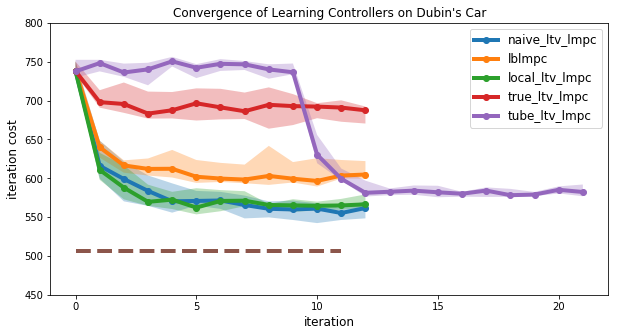

In [9]:
colors = ["r", "g","b","c","m","y","k"]
plt.figure(figsize=(10,5))
for iteration_cost,c in zip(iteration_costs[:-1], colors):
    plot_with_bars_qts(iteration_cost[:,9:-3])
plot_with_bars_qts(iteration_costs[-1][:,:-3])
plt.plot(np.arange(12), np.ones(12) * noiseless_scp_optimal, "--", lw=4, label="noiseless SCP opt")
plt.legend(controllers[1:],loc="upper right")
plt.ylim((450,800))
plt.xlabel("iteration")
plt.ylabel("iteration cost")
plt.title("Convergence of Learning Controllers on Dubin's Car")
# plt.savefig(save_dir + "converge_quartiles.png")

In [7]:
delta_lim = np.pi / 6
a_lim = 0.3
vlims = [-.1, 1]
n = 100
dt = 0.1
init_input_trajs = [d["u_trajs"] for d in data[TRACKING_LMPC]]
local_input_trajs = [d["u_trajs"] for d in data[LOCAL_LMPC]]
init_x_trajs = [d["x_trajs"] for d in data[TRACKING_LMPC]]
local_x_trajs = [d["x_trajs"] for d in data[LOCAL_LMPC]]

init_a_trajs, init_delta_trajs = zip(*[(u_traj[-1][:,0], u_traj[-1][:,1]) for u_traj in init_input_trajs])
a_trajs, delta_trajs = zip(*[(u_traj[-1][0,:], u_traj[-1][1,:]) for u_traj in local_input_trajs])
init_v_trajs = [x_traj[-1][:,3] for x_traj in init_x_trajs]
v_trajs = [x_traj[-1][3,:] for x_traj in local_x_trajs]
init_a_trajs = np.vstack(init_a_trajs)
a_trajs = np.vstack(a_trajs)
init_delta_trajs = np.vstack(init_delta_trajs)
delta_trajs = np.vstack(delta_trajs)
init_v_trajs = np.vstack(init_v_trajs)
v_trajs = np.vstack(v_trajs)

In [184]:
def plot_with_bars_qts(ax, x, y, alpha=0.3, lw=4, linestyle="o-", label=""):
    q2 = np.quantile(y, 0.5, axis=0)
    q1 = np.quantile(y, 0.25, axis=0)
    q3 = np.quantile(y, 0.75, axis=0)
    ax.fill_between(x, q1, q3, alpha=alpha, label=label)
    ax.plot(x, q2, linestyle, lw=lw, label=label)
    

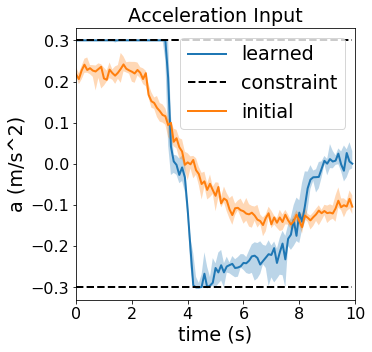

In [199]:
lw=2
ts = np.arange(n) * dt
figsize = (5,5)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_with_bars_qts(ax, ts, a_trajs, lw=lw, linestyle="-", label="learned")
plot_with_bars_qts(ax, ts, init_a_trajs, lw=lw, linestyle="-", label="initial")
ax.plot(ts, [-a_lim] * n, "k--", label="constraint", lw=lw)
ax.plot(ts, [a_lim] * n, "k--", label="constraint", lw=lw)
ax.set_xlabel("time (s)")
ax.set_ylabel("a (m/s^2)")
ax.set_xlim((0,10))
handles, labels = ax.get_legend_handles_labels()
idx = [0,3,1]
handles = [handles[i] for i in idx]
labels = [labels[i] for i in idx]
plt.legend(handles, labels, loc="upper right")
plt.title("Acceleration Input")
plt.savefig(save_dir + "local_accelerations.png",bbox_inches="tight")

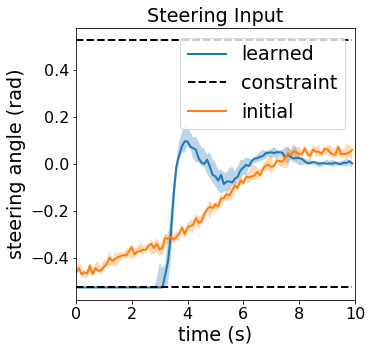

In [198]:
lw=2
ts = np.arange(n) * dt
figsize = (5,5)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_with_bars_qts(ax, ts, delta_trajs, lw=lw, linestyle="-", label="learned")
plot_with_bars_qts(ax, ts, init_delta_trajs, lw=lw, linestyle="-", label="initial")
ax.plot(ts, [-delta_lim] * n, "k--", label="constraint", lw=lw)
ax.plot(ts, [delta_lim] * n, "k--", label="constraint", lw=lw)
ax.set_xlabel("time (s)")
ax.set_ylabel("steering angle (rad)")
ax.set_xlim((0,10))
handles, labels = ax.get_legend_handles_labels()
idx = [0,3,1]
handles = [handles[i] for i in idx]
labels = [labels[i] for i in idx]
plt.legend(handles, labels, loc="upper right")
plt.title("Steering Input")
plt.savefig(save_dir + "local_steering.png",bbox_inches="tight")

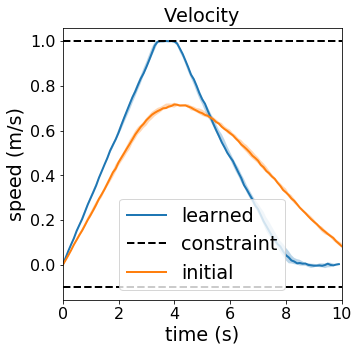

In [197]:
lw=2
ts = np.arange(n+1) * dt
figsize = (5,5)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_with_bars_qts(ax, ts[:-1], v_trajs, lw=lw, linestyle="-", label="learned")
plot_with_bars_qts(ax, ts, init_v_trajs, lw=lw, linestyle="-", label="initial")
ax.plot(ts, [vlims[0]] * (n+1), "k--", label="constraint", lw=lw)
ax.plot(ts, [vlims[1]] * (n+1), "k--", label="constraint", lw=lw)
ax.set_xlabel("time (s)")
ax.set_ylabel("speed (m/s)")
ax.set_xlim((0,10))
handles, labels = ax.get_legend_handles_labels()
idx = [0,3,1]
handles = [handles[i] for i in idx]
labels = [labels[i] for i in idx]
plt.legend(handles, labels, loc="lower center")
plt.title("Velocity")
plt.savefig(save_dir + "local_speed.png", bbox_inches="tight")

## Plot sysid data

In [86]:
n_states = 4
n_inputs = 2
dt = 0.1
init_state = np.array([-3.5,0, np.pi/2, 0])
linearization_state = np.zeros(n_states)
linearization_input = np.zeros(n_inputs)

h = 2
lamb = 1e-2
n_sysid_pts = 500
n_sysid_it = 10

Q = np.diag([1, 10, 1, 1]) 
R = np.eye(n_inputs)

# State and Input Constraints
delta_lim = np.pi / 6
a_lim = 0.3
input_limits = polytope.box2poly([[-a_lim, a_lim], [-delta_lim, delta_lim]])
state_limits = polytope.box2poly([[-4,1],[-1,1],[-5 * np.pi, 5 *np.pi],[-0.1,1]])

vehicle = dynamics_models.DubinCar(np.zeros(n_states), dt, np.eye(n_states), use_ode_integrator=False)
A, B, C = vehicle.get_linearization(linearization_state, linearization_input, dt)
A[1,2] = 0.025
K, _ , _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)

l = 0.125
w = 0.075
figsize = (8,4)
state_lims_proj = state_limits.project([1,2])

def plot_experiment(traj_list, x_preds, ax, xlims=(-5,2), ylims=(-1.5, 1.5), lw=2, k=10,bbox=(0,0)):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("x in (m)")
    ax.set_ylabel("y in (m)")
    state_lims_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
    
    for x_traj in traj_list:
        ss = ax.plot(x_traj[0,:], x_traj[1,:], "r--", label="safe set")
        
    for pred in x_preds:
        ps = ax.plot(pred[:,0], pred[:,1], color="tab:blue", linestyle="--", alpha=0.6, label="predictions")
        
    x_traj = traj_list[-1].T
    ts = ax.plot(x_traj[:,0], x_traj[:,1], "k", lw=lw, label="final trajectory")
    patches = [dynamics_models.plot_vehicle(x[:3], l, w, alpha=0.4) for x in np.rollaxis(x_traj[::k,:],0)]
    for patch in patches:
        ax.add_patch(patch)
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[(handles[i], labels[i]) for i in [0,-1,-2]])
    handles = list(handles)
    labels = list(labels)
    handles.append(ax.patches[0])
    labels.append("state constraints")
    ax.legend(handles, labels, bbox_to_anchor=bbox)

In [87]:
id_data = data[TRACKING_LMPC]
x_trajs = id_data[0]["x_trajs"]
u_trajs = id_data[0]["u_trajs"]
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_trajs, u_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [125]:
n_tv = 50
n_xy = 50
x_vals = np.linspace(-4, 1, num=n_xy)
y_vals = np.linspace(-1, 1, num=n_xy)
theta_vals = np.linspace(-5 * np.pi, 5 * np.pi, num=n_tv)
v_vals = np.linspace(-0.1,1, num=n_tv)
base_data = np.array(list(itertools.product(theta_vals, v_vals)))
base_data = np.hstack((np.ones((base_data.shape[0], 2)), base_data))

## Global Uncertainties

In [96]:
uncerts = np.zeros((len(x_vals), len(y_vals)))
true_errs = np.zeros(uncerts.shape)
for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        test_data = base_data.copy()
        test_data[:,0] = test_data[:,0] * x
        test_data[:,1] = test_data[:,1] * y
        u_data = - test_data @ K.T
        preds, covs = model.predict(test_data, u_data)
        true_preds = [vehicle.f_discrete(test_data[i,:], u_data[i,:], dt) for i in range(test_data.shape[0])]
        true_preds = np.array(true_preds)
        true_errors = np.linalg.norm(preds - true_preds, axis=1)
        true_errs[i,j] = np.min(true_errors)
        uncerts[i,j] = np.min(covs)

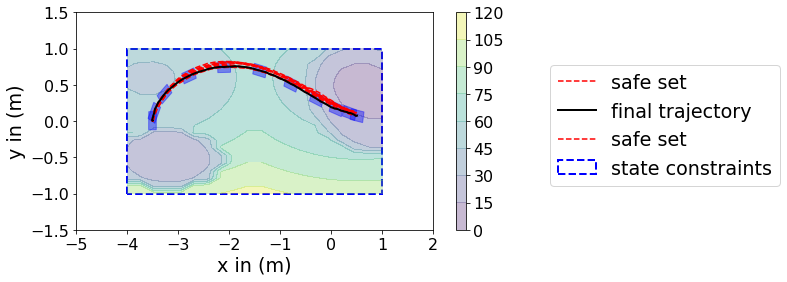

In [97]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x.T for x in x_trajs], [], ax, bbox=(1.3,.8))
plt.contourf(x_vals, y_vals, 1.96 * np.sqrt(uncerts), alpha=0.3)
plt.colorbar()

## True Errors

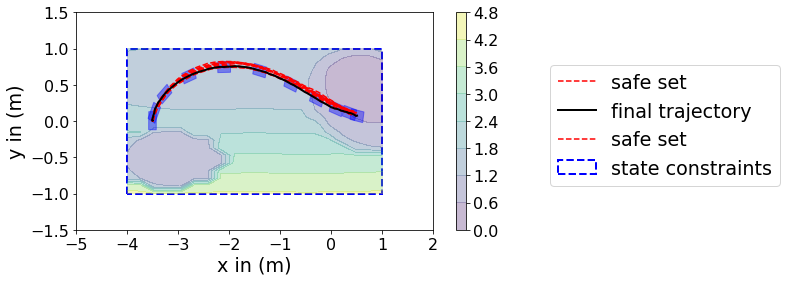

In [98]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x.T for x in x_trajs], [], ax, bbox=(1.3,.8))
plt.contourf(x_vals, y_vals, true_errs, alpha=0.3)
plt.colorbar()

## Along last recorded trajectory

In [138]:
As, Bs, Cs, Qs, errs = model.regress_models(x_trajs[-1], u_trajs[-1])
k = 1
Qs = Qs[::k]

In [139]:
uncerts = np.zeros((len(x_vals), len(y_vals)))
for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        test_data = base_data.copy()
        test_data[:,0] = test_data[:,0] * x
        test_data[:,1] = test_data[:,1] * y
        u_data = - test_data @ K.T
        zs = np.hstack((test_data, u_data, np.ones((u_data.shape[0], 1))))
        covs = [[z.T @ Q @ z for z in np.rollaxis(zs, 0)] for Q in Qs]
        covs = np.hstack(covs)
        uncerts[i,j] = np.min(covs)

KeyboardInterrupt: 

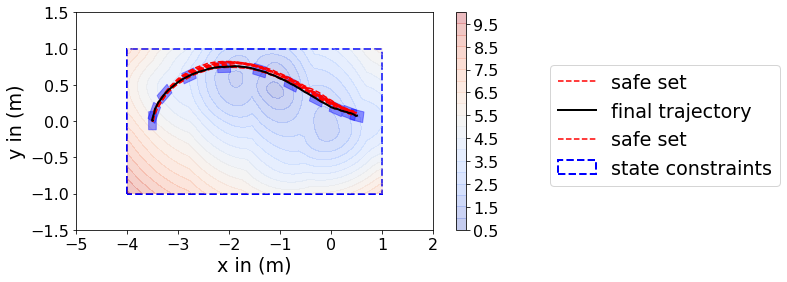

In [137]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x.T for x in x_trajs], [], ax, bbox=(1.3,.8))
plt.contourf(x_vals, y_vals, 1.96 * np.sqrt(uncerts), 20, alpha=0.3, cmap="coolwarm")
plt.colorbar()

## SCP LMPC with uncertainty cost

In [41]:
SCP_nrnu = "no_reg_no_uncert"
SCP_reg = "reg"
SCP_both = "reg_and_uncert"
SCP_uncert = "uncert"
controllers = [SCP_nrnu, SCP_reg, SCP_both, SCP_uncert]

In [42]:
save_dir = "dubin_car_expts_scp_lmpc/"
data = {controller:experiment_utils.load_results(save_dir, controller) for controller in controllers}
iteration_costs = [np.vstack(compute_iteration_costs(experiment) for experiment in data[controller]) for controller in controllers[:]]

C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,"Convergence of Learning Controllers on Dubin's Car")

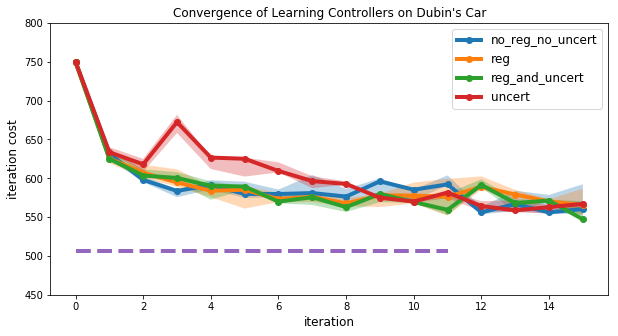

In [43]:
colors = ["r", "g","b","c"]
plt.figure(figsize=(10,5))
for iteration_cost,c in zip(iteration_costs, colors):
    plot_with_bars_qts(iteration_cost[:,9:])
# plot_with_bars_qts(iteration_costs[-1][:,:-3])
plt.plot(np.arange(12), np.ones(12) * noiseless_scp_optimal, "--", lw=4, label="noiseless SCP opt")
plt.legend(controllers[:],loc="upper right")
plt.ylim((450,800))
plt.xlabel("iteration")
plt.ylabel("iteration cost")
plt.title("Convergence of Learning Controllers on Dubin's Car")
# plt.savefig(save_dir + "converge_quartiles.png")